<a href="https://colab.research.google.com/github/ToshimiGunji/Insect-Eating/blob/master/stockProgram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install shap 

     |████████████████████████████████| 358kB 5.7MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491617 sha256=9bb801b121169c1ee0631a1819b03048a497fae7e66f56b1558dbf50f7b82a33
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [2]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm

# 表示用の設定を変更します
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [3]:

dataset_dir="/content/drive/MyDrive/機械学習/stockProgram/data_dir"
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)
    # DataFrameのindexを設定します。
    if k == "stock_price":
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "EndOfDayQuote Date"]
        )
        dfs[k].set_index("datetime", inplace=True)
    elif k in ["stock_fin", "stock_fin_price", "stock_labels"]:
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "base_date"]
        )
        dfs[k].set_index("datetime", inplace=True)

stock_list
stock_price
stock_fin
stock_labels


#ここまでがデータの準備

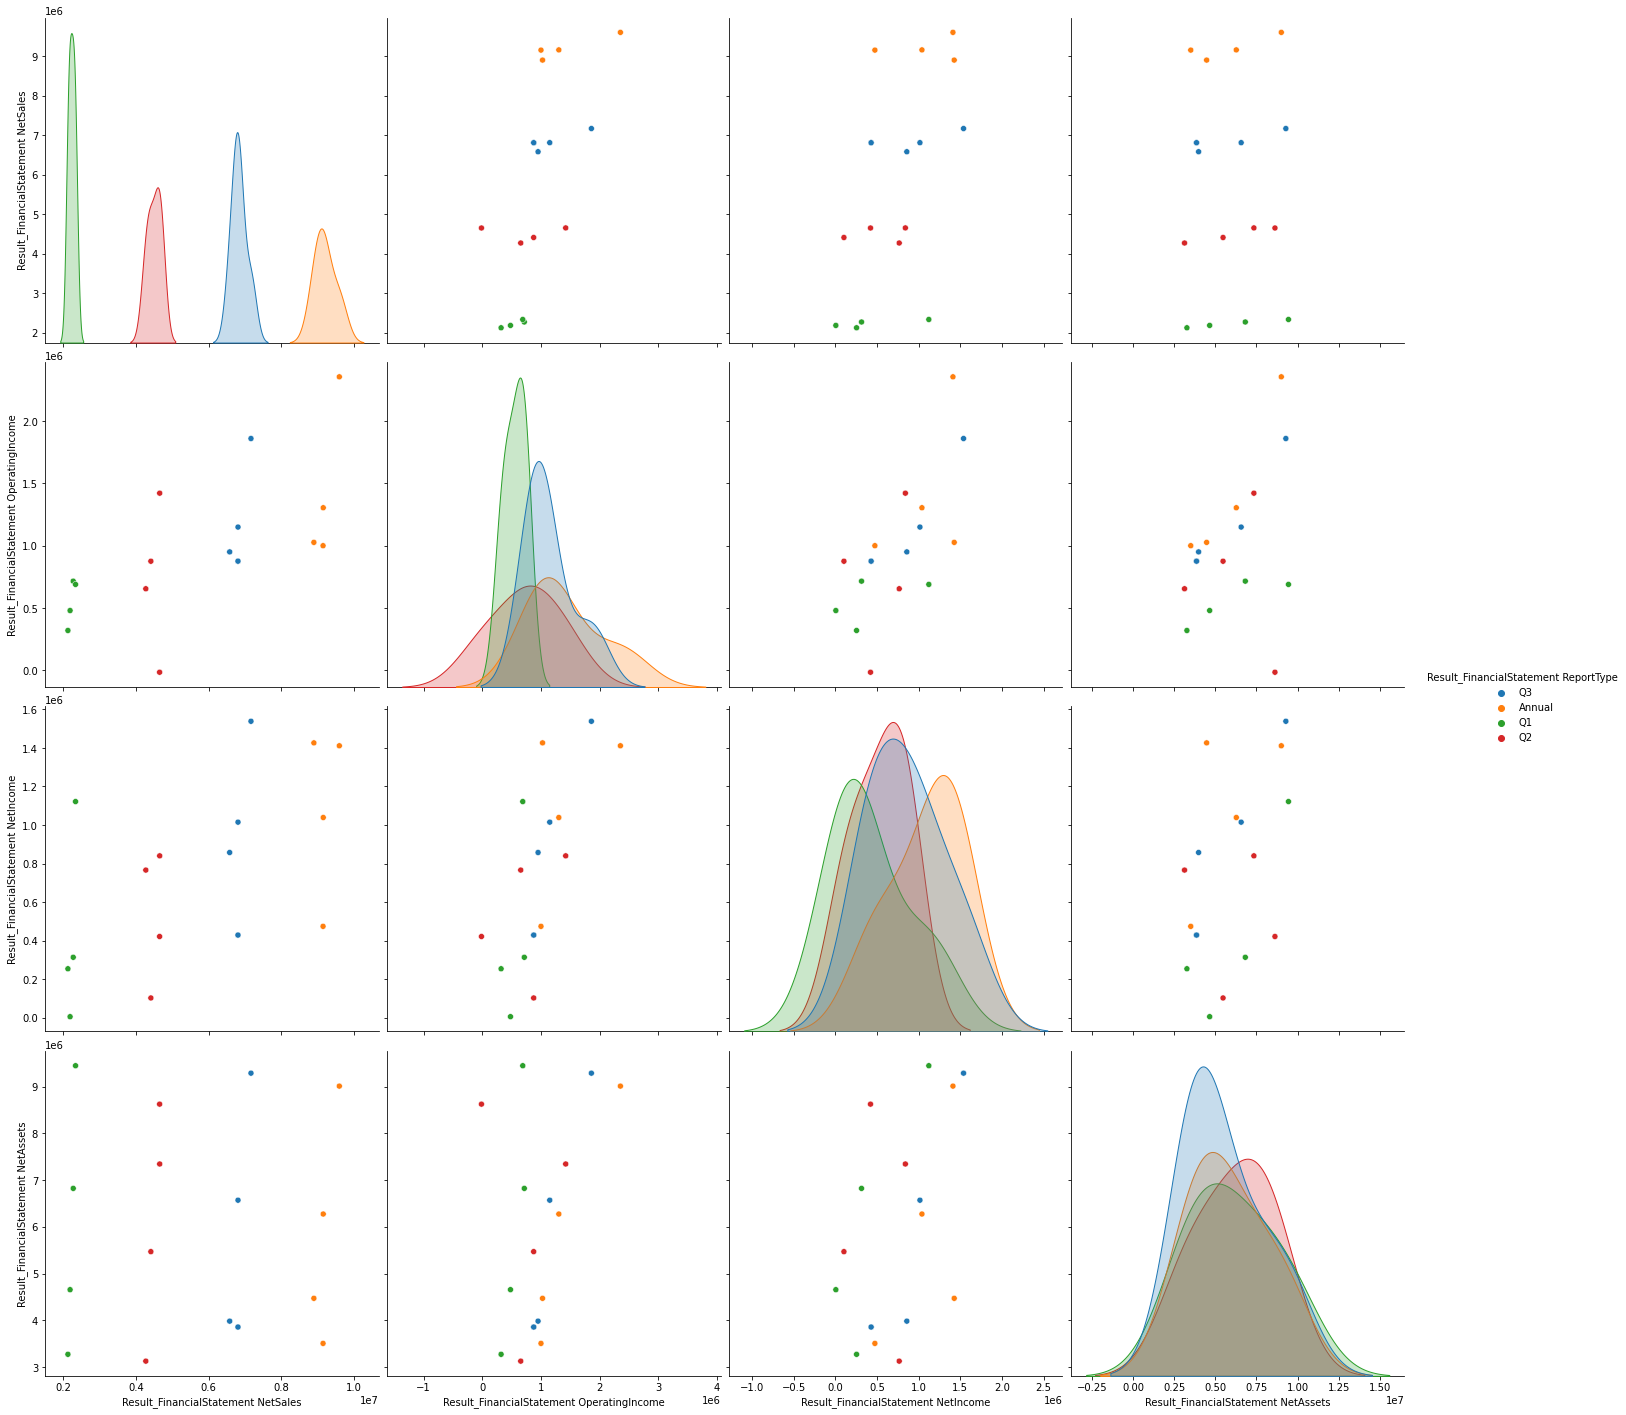

In [4]:
# stock_finの読み込み
fin = dfs["stock_fin"]

# 銘柄コード9984にデータを絞る
code = 9984
fin_data = fin[fin["Local Code"] == code]

# 2019年までの値を表示
fin_data = fin_data[:"2019"]

# プロット対象を定義
columns = [
    "Result_FinancialStatement NetSales",  # 売上高
    "Result_FinancialStatement OperatingIncome",  # 営業利益
    "Result_FinancialStatement NetIncome",  # 純利益
    "Result_FinancialStatement NetAssets",  # 純資産
    "Result_FinancialStatement ReportType"  # 決算期
]

# プロット
sns.pairplot(fin_data[columns], hue="Result_FinancialStatement ReportType", height=5)
plt.show()

In [ ]:
code = 9984
fin_data = fin[fin["Local Code"] == code]
fin_data = fin_data[:"2019"]
fin_data

In [ ]:
# stock_finの読み込み
fin = dfs["stock_fin"]

# 銘柄コード9984と9983を比較する
codes = [9984, 9983]

multi_df = dict()

# プロット対象を定義
columns = [
    "Result_FinancialStatement NetSales",  # 売上高
    "Result_FinancialStatement OperatingIncome",  # 営業利益
    "Result_FinancialStatement NetIncome",  # 純利益
    "Result_FinancialStatement NetAssets",  # 純資産
    "Result_FinancialStatement ReportType"  # 決算期
]

# 比較対象の銘柄コード毎に処理
for code in codes:
    # 特定の銘柄コードに絞り込み
    fin_data = fin[fin["Local Code"] == code]
    # 2019年までの値を表示
    fin_data = fin_data[:"2019"].copy()
    # 重複を排除
    fin_data.drop_duplicates(
        subset=[
            "Local Code",
            "Result_FinancialStatement FiscalYear",
            "Result_FinancialStatement ReportType"
        ],
        keep="last", inplace=True)
    # プロット対象のカラムを取得
    _fin_data = fin_data[columns]
    # 決算期毎の平均を取得
    multi_df[code] = _fin_data[columns].groupby("Result_FinancialStatement ReportType").mean()

# 銘柄毎に処理していたものを結合
multi_df = pd.concat(multi_df)
# 凡例を調整
multi_df.set_index(multi_df.index.map(lambda t: f"{t[0]}/{t[1]}"), inplace=True)
# プロット
ax = multi_df.T.plot(kind="bar", figsize=(12, 6), grid=True)
# Y軸のラベルを調整
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: "{} bYen".format(int(x / 1_000))))

In [ ]:
# stock_priceの読み込み
price = dfs["stock_price"]

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"]

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(price_data["EndOfDayQuote ExchangeOfficialClose"], label=f"securities code : {code}.T")
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

In [ ]:
# stock_priceの読み込み
price = dfs["stock_price"]

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"].copy()

# 5日、25日、75日の移動平均を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].rolling(period, min_periods=1).mean()
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

In [ ]:
# stock_priceの読み込み
price = dfs["stock_price"]

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"].copy()

# 5日、25日、75日の価格変化率を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].pct_change(period) * 100
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("rate of return (%)")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

#データの前処理


(64448, 44)
base_date                                                         0
Local Code                                                        0
Result_FinancialStatement AccountingStandard                    240
Result_FinancialStatement FiscalPeriodEnd                       240
Result_FinancialStatement ReportType                            240
Result_FinancialStatement FiscalYear                            240
Result_FinancialStatement ModifyDate                            240
Result_FinancialStatement CompanyType                           240
Result_FinancialStatement ChangeOfFiscalYearEnd                 240
Result_FinancialStatement NetSales                              257
Result_FinancialStatement OperatingIncome                      2073
Result_FinancialStatement OrdinaryIncome                        309
Result_FinancialStatement NetIncome                             243
Result_FinancialStatement TotalAssets                           241
Result_FinancialStatement NetAssets 

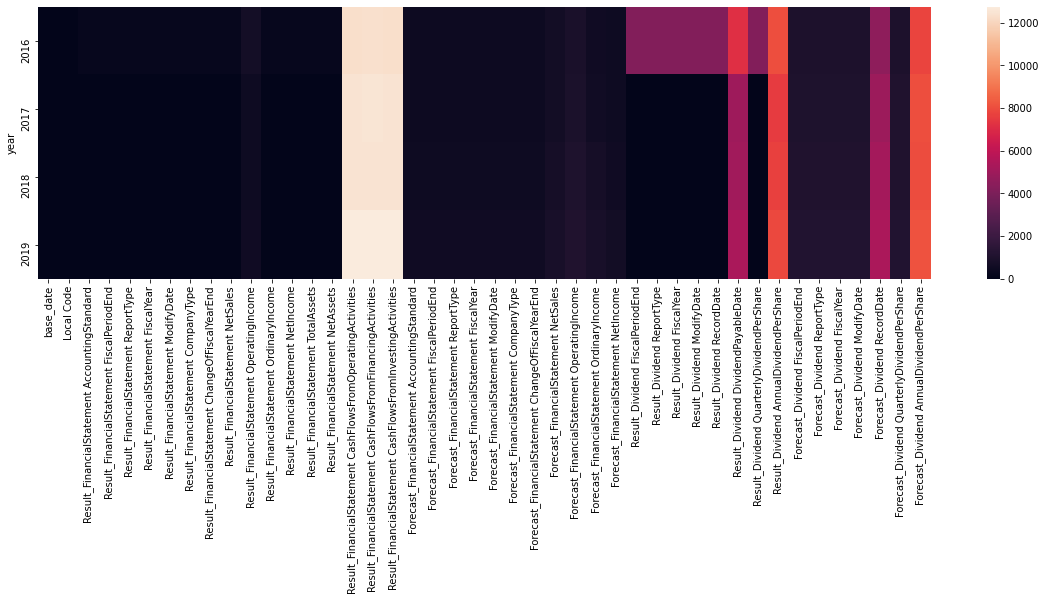

In [13]:
# stock_finデータを読み込む
stock_fin = dfs["stock_fin"]

# 2019年までの値を表示
stock_fin = stock_fin[:"2019"]

# データ数の確認
print(stock_fin.shape)

# データの欠損値数を確認
print(stock_fin.isna().sum())

# 欠損値の数を年別に集計
stock_fin = stock_fin.isna()
stock_fin["year"] = stock_fin.index.year

# データの欠損値をプロット
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(stock_fin.groupby("year").agg("sum"), ax=ax)

In [17]:
# stock_finデータを読み込む
stock_fin = dfs["stock_fin"]

# 銘柄コード9984にデータを絞る
code = 9984
stock_fin = stock_fin[stock_fin["Local Code"] == code]

# float64型の列に絞り込み
fin_data = stock_fin.select_dtypes(include=["float64"])

# 欠損値を0でフィル
fin_data = fin_data.fillna(0)

%load_ext google.colab.data_table
# %unload_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [19]:
fin_data
print(fin_data)

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


,Result_FinancialStatement FiscalYear,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalYear,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalYear,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare
datetime,,,,,,,,,,,,,,,,,,,,,
2016-02-10,2016.0,6810206.0,875322.0,918214.0,428972.0,21497648.0,3855507.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016.0,20.0,40.0
2016-04-21,2016.0,6810206.0,875322.0,918214.0,428972.0,21497648.0,3855507.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016.0,21.0,41.0
2016-05-10,2016.0,9153549.0,999488.0,1005764.0,474172.0,20707192.0,3505271.0,940186.0,43270.0,-1651682.0,0.0,0.0,0.0,0.0,0.0,2016.0,21.0,41.0,2017.0,22.0,0.0
2016-07-28,2017.0,2126521.0,319236.0,356361.0,254157.0,20622229.0,3271996.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016.0,21.0,41.0,2017.0,22.0,0.0
2016-11-07,2017.0,4271834.0,653944.0,665625.0,766249.0,22896077.0,3126322.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,22.0,0.0,2017.0,22.0,44.0
2017-02-08,2017.0,6581466.0,949660.0,975257.0,857431.0,24867038.0,3981711.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,22.0,0.0,2017.0,22.0,44.0
2017-05-10,2017.0,8901004.0,1025999.0,712526.0,1426308.0,24634212.0,4469730.0,1500728.0,2380746.0,-4213597.0,0.0,0.0,0.0,0.0,0.0,2017.0,22.0,44.0,2018.0,22.0,0.0
2017-08-07,2018.0,2186059.0,479273.0,77568.0,5521.0,24883131.0,4654749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,22.0,44.0,2018.0,22.0,0.0
2017-11-06,2018.0,4411135.0,874839.0,219021.0,102622.0,27973483.0,5468373.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,22.0,0.0,2018.0,22.0,44.0
